In [1]:
import math
import numpy as np
import seaborn as sns
from keras import Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras_tuner import BayesianOptimization
from matplotlib import pyplot as plt
import pandas_ta as ta
import pandas as pd
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from dotenv import load_dotenv
load_dotenv()

True

# Data Collection

In [2]:
# microsofts stock symbol listing
msft_symbol = "MSFT"
# file name microsofts stock will be saved as
file_name = msft_symbol + "_df.pickle"

# tries to read cached file from api otherwise requests api
try:
    msft_df = pd.read_pickle(file_name)
except Exception:
    # gets key from environment
    vantage_key = os.environ.get('VANTAGE_KEY')
    # api url
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={msft_symbol}&apikey={vantage_key}&datatype=csv&outputsize=full'
    # queries api and returns dataframe from the csv output
    msft_df = pd.read_csv(url)
    # saves file
    msft_df.to_pickle(file_name)

In [3]:
msft_df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2023-04-06,283.21,292.0800,282.03,291.60,291.60,29770334,0.0,1.0
1,2023-04-05,285.85,287.1500,282.92,284.34,284.34,22064770,0.0,1.0
2,2023-04-04,287.23,290.4499,285.67,287.18,287.18,25824299,0.0,1.0
3,2023-04-03,286.52,288.2700,283.95,287.23,287.23,24883342,0.0,1.0
4,2023-03-31,283.73,289.2700,283.00,288.30,288.30,32765976,0.0,1.0


# Data Cleaning

In [4]:
# sets timestamp as index
msft_df.set_index('timestamp', inplace=True)
# reverse dataframe
msft_df = msft_df.iloc[::-1]
# change to datetime
msft_df.index = pd.to_datetime(msft_df.index)

# Exploring the data

In [5]:
print(msft_df.describe())

              open         high          low        close  adjusted_close   
count  5896.000000  5896.000000  5896.000000  5896.000000     5896.000000  \
mean     75.406594    76.246424    74.560749    75.426900       63.989179   
std      76.057929    76.870936    75.201722    76.083609       78.929547   
min      15.200000    15.620000    14.870000    15.150000       11.377337   
25%      27.380000    27.640000    27.190000    27.400000       19.092309   
50%      43.280000    43.932500    42.954950    43.410000       23.418630   
75%      83.167500    83.707500    82.750000    83.127500       64.166330   
max     344.620000   349.670000   342.200000   343.110000      339.030180   

             volume  dividend_amount  split_coefficient  
count  5.896000e+03      5896.000000        5896.000000  
mean   4.662765e+07         0.004279           1.000170  
std    2.750685e+07         0.055714           0.013023  
min    5.850800e+06         0.000000           1.000000  
25%    2.769441e

In [6]:
print(msft_df.tail())

              open      high     low   close  adjusted_close    volume   
timestamp                                                                
2023-03-31  283.73  289.2700  283.00  288.30          288.30  32765976  \
2023-04-03  286.52  288.2700  283.95  287.23          287.23  24883342   
2023-04-04  287.23  290.4499  285.67  287.18          287.18  25824299   
2023-04-05  285.85  287.1500  282.92  284.34          284.34  22064770   
2023-04-06  283.21  292.0800  282.03  291.60          291.60  29770334   

            dividend_amount  split_coefficient  
timestamp                                       
2023-03-31              0.0                1.0  
2023-04-03              0.0                1.0  
2023-04-04              0.0                1.0  
2023-04-05              0.0                1.0  
2023-04-06              0.0                1.0  


In [7]:
print(msft_df.shape)

(5896, 8)


# Data Visualization

In [8]:
msft_df = msft_df.sort_index().loc['2016-01-01':'2023-01-01'] # gets data 2016 onwards

<Axes: xlabel='timestamp'>

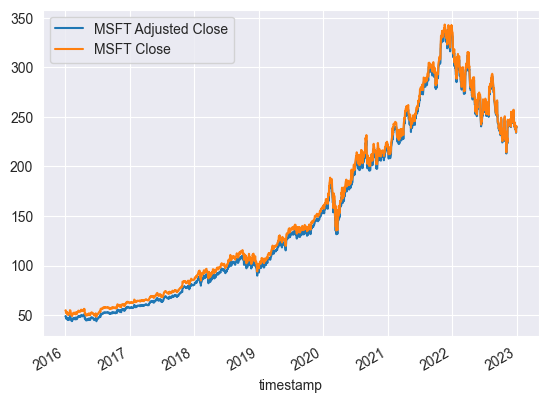

In [9]:
msft_df["adjusted_close"].plot(label="MSFT Adjusted Close", legend=True)
msft_df["close"].plot(label="MSFT Close", legend=True)

<Axes: xlabel='timestamp'>

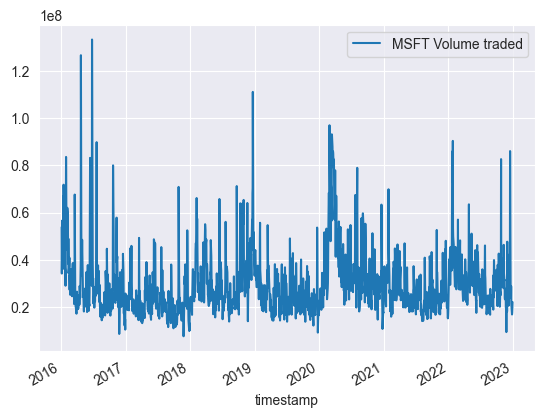

In [10]:
msft_df["volume"].plot(label="MSFT Volume traded", legend=True)

Text(0.5, 0, 'Change in adjusted close (1 day)')

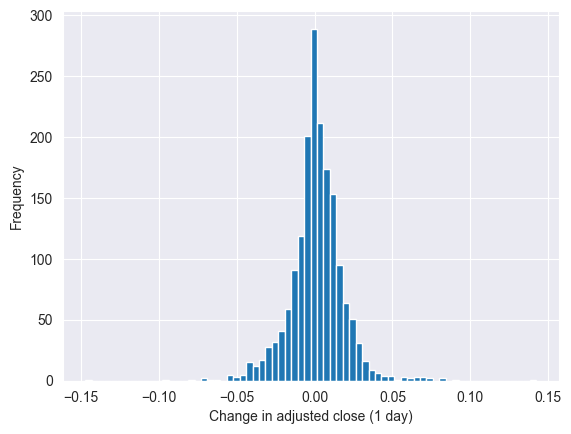

In [11]:
msft_df['adjusted_close'].pct_change().plot.hist(bins=70)
plt.xlabel("Change in adjusted close (1 day)")

Text(0.5, 0, 'Change in adjusted close (10 day)')

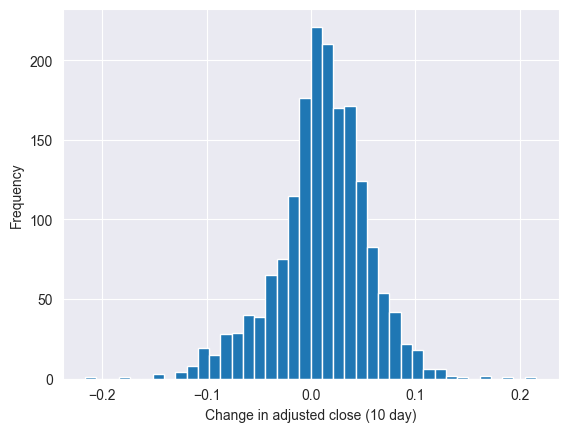

In [12]:
msft_df['adjusted_close'].pct_change(10).plot.hist(bins=40)
plt.xlabel("Change in adjusted close (10 day)")

<Axes: xlabel='timestamp'>

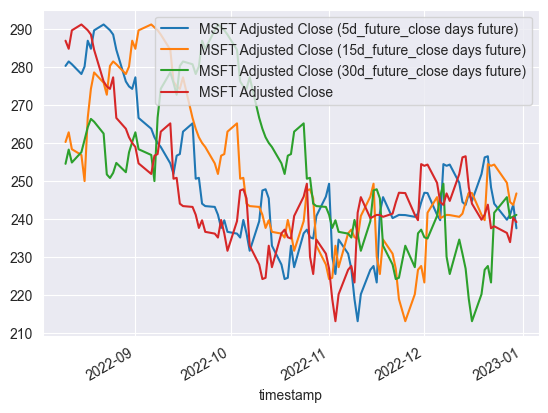

In [13]:
# feature engineering
for future_day in [5, 15, 30]:
    day_feature_name = str(future_day) + 'd_future_close'
    msft_df[day_feature_name] = msft_df['adjusted_close'].shift(future_day)
    msft_df.tail(100)[day_feature_name].plot(label=f"MSFT Adjusted Close ({day_feature_name} days future)", legend=True)
msft_df.tail(100)["adjusted_close"].plot(label="MSFT Adjusted Close", legend=True)

# Feature Engineering

In [14]:
# target engineering
msft_df['30d_adj_close_future_percent'] = msft_df['adjusted_close'].pct_change(30)
# names of targets
target_identity = ['30d_adj_close_future_percent']

# feature engineering
feature_identities = ['adjusted_close']

# engineering RSI and SMA
for moving_avg_len in [7, 50, 100, 200]:
    msft_df['sma' + str(moving_avg_len)] = ta.sma(msft_df['adjusted_close'], length=moving_avg_len, talib=True)
    msft_df['rsi' + str(moving_avg_len)] = ta.rsi(msft_df['adjusted_close'], length=moving_avg_len, talib=True)
    feature_identities += ['sma' + str(moving_avg_len), 'rsi' + str(moving_avg_len)]


# Data Normalization

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
# copy original values before normalizing
msft_df['adjusted_close_real'] = msft_df['adjusted_close']
# transform data
msft_df[feature_identities] = scaler.fit_transform(msft_df[feature_identities])

In [16]:
msft_df.dropna(inplace=True)
identities = feature_identities + target_identity

# Viewing Correlations

In [17]:
correlation_matrix = msft_df[identities].corr()

<Axes: >

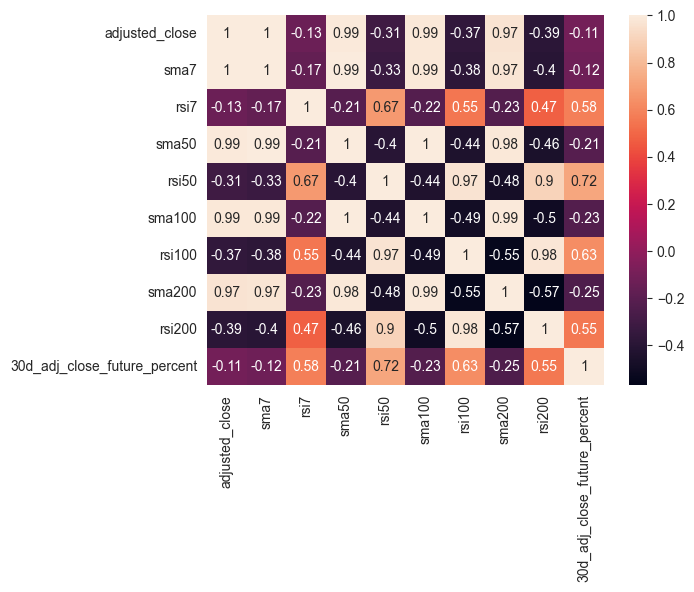

In [18]:
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size" : 10})

In [19]:
feature_identities = ['adjusted_close', 'rsi50', 'sma200']

# Creating rolling window

In [20]:
def create_rolling_windows(data, win_size):
    print(data)
    """
    Converts dataframe into two windowed numpy arrays
    :param data: dataframe including the features and target as the last column
    :param win_size: the size of the window for the NN
    :return: Features as a numpy array and Target as numpy array
    """
    X, y = [], []
    for i in range(len(data) - win_size):
        ## adds features to rolling window
        X.append(data[i:i + win_size, :-1])
        ## adds target to rolling window
        y.append(data[i + win_size, -1])
    return np.array(X), np.array(y)

# the size of the window
window_size = 120
# creates rolling windows
X, y = create_rolling_windows(msft_df[feature_identities + target_identity].values, window_size)
# splits rolling windows into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.30, shuffle=False)

[[ 2.94782889e-02  4.49385352e-01  7.15956757e-05  8.67904878e-04]
 [ 2.90762408e-02  4.37229794e-01  1.36420869e-04 -2.25459591e-03]
 [ 2.82102911e-02  4.11090463e-01  2.13882703e-04 -3.13425039e-03]
 ...
 [ 6.43886726e-01  1.79696320e-01  8.35085056e-01 -2.63310039e-02]
 [ 6.65789701e-01  2.34017996e-01  8.34216123e-01 -1.16553870e-03]
 [ 6.61767395e-01  2.24844935e-01  8.33181875e-01 -7.90137757e-03]]


In [21]:
X_train.shape

(1009, 120, 3)

In [22]:
y_train.shape

(1009,)

# Developing the model

In [23]:
def create_stock_forecaster_lstm(hp):
    """
    Creates a Neural Network containing a LSTM and Dense hidden layer.
    :param hp: Hyperparameter tuner
    :return: the NN model instance
    """
    stock_model = Sequential()
    stock_model.add(Input((window_size, 3)))
    stock_model.add(LSTM(hp.Int('units_lstm', min_value=64, max_value=512, step=64)))
    stock_model.add(Dropout(0.2)) # reduces overfitting
    stock_model.add(Dense(hp.Int('units_dense', min_value=32, max_value=256, step=32), activation=hp.Choice('activation', ['relu', 'tanh'])))
    stock_model.add(Dense(units=1))
    stock_model.compile(optimizer='adam', loss='mean_squared_error')
    return stock_model

# optimizer for neural network, attempts 10 trials
tuner = BayesianOptimization (
    create_stock_forecaster_lstm,
    objective='val_loss',
    max_trials=10,
    seed=21,
    directory='lstm')

# invoke the tuner to find the best neural network model, each hyperparameter model is given 20 epoch's
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))
# gets best model
model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 26s]
val_loss: 0.00223208824172616

Best val_loss So Far: 0.0018432532669976354
Total elapsed time: 00h 21m 26s
INFO:tensorflow:Oracle triggered exit


# Results

In [24]:
# summary of the hyperparameter search
tuner.results_summary(num_trials=10)

Results summary
Results in lstm\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
units_lstm: 384
units_dense: 32
activation: tanh
Score: 0.0018432532669976354

Trial 05 summary
Hyperparameters:
units_lstm: 192
units_dense: 192
activation: tanh
Score: 0.002007724018767476

Trial 06 summary
Hyperparameters:
units_lstm: 128
units_dense: 128
activation: relu
Score: 0.0020155669189989567

Trial 07 summary
Hyperparameters:
units_lstm: 384
units_dense: 32
activation: relu
Score: 0.0022152140736579895

Trial 08 summary
Hyperparameters:
units_lstm: 192
units_dense: 256
activation: relu
Score: 0.0022294428199529648

Trial 09 summary
Hyperparameters:
units_lstm: 64
units_dense: 96
activation: tanh
Score: 0.00223208824172616

Trial 04 summary
Hyperparameters:
units_lstm: 320
units_dense: 160
activation: tanh
Score: 0.00225879717618227

Trial 01 summary
Hyperparameters:
units_lstm: 384
units_dense: 128
activation: tanh
Score: 0.0

Epoch 1/25
32/32 [==============================] - 13s 344ms/step - loss: 0.0012 - val_loss: 0.0198
Epoch 2/25
32/32 [==============================] - 10s 321ms/step - loss: 0.0012 - val_loss: 0.0385
Epoch 3/25
32/32 [==============================] - 10s 322ms/step - loss: 0.0011 - val_loss: 0.0635
Epoch 4/25
32/32 [==============================] - 10s 327ms/step - loss: 0.0010 - val_loss: 0.1060
Epoch 5/25
32/32 [==============================] - 10s 326ms/step - loss: 0.0010 - val_loss: 0.0033
Epoch 6/25
32/32 [==============================] - 10s 324ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 7/25
32/32 [==============================] - 10s 325ms/step - loss: 0.0013 - val_loss: 0.0141
Epoch 8/25
32/32 [==============================] - 11s 342ms/step - loss: 0.0011 - val_loss: 0.0071
Epoch 9/25
32/32 [==============================] - 10s 327ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 10/25
32/32 [==============================] - 10s 324ms/step - loss: 0.0012 - val_lo

Text(0.5, 1.0, 'loss:0.000985')

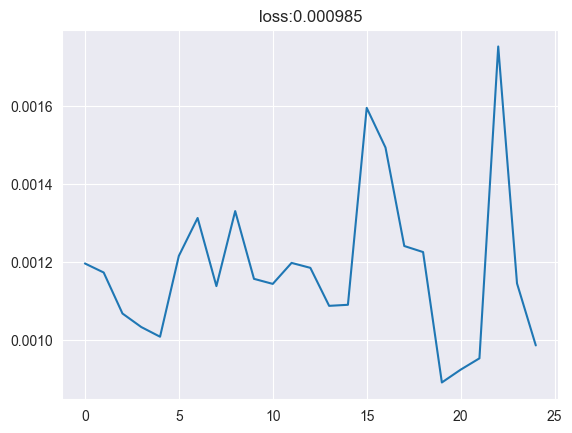

In [25]:
# plot loss function for best model
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25)
plt.plot(hist.history['loss'])
plt.title('loss:' + str(round(hist.history['loss'][-1], 6)))

14/14 [==============================] - 2s 119ms/step
MSE: 0.015090214406261774
RMSE: 0.12284223380524213
R^2: -1.092364897799421
MAE: 0.09079918981708118


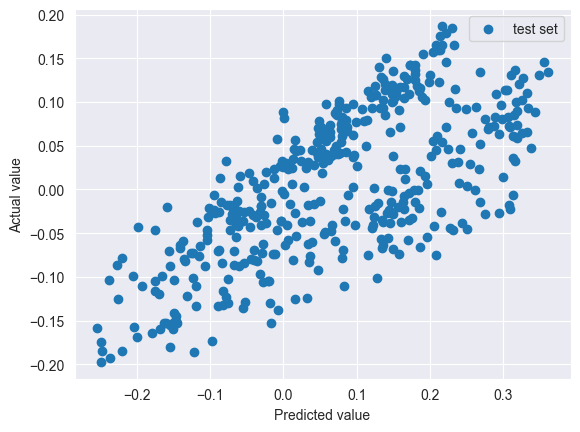

In [26]:
# predictions based on test features
y_prediction = model.predict(X_test)

# plots predictions against actual targets
plt.scatter(y_prediction, y_test, label='test set')

# plots test set
# y = mx + c
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.legend()

# results
mse = mean_squared_error(y_test, y_prediction)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_prediction)
mae = mean_absolute_error(y_test, y_prediction)
print(f'MSE: {mse}\nRMSE: {rmse}\nR^2: {r2}\nMAE: {mae}')

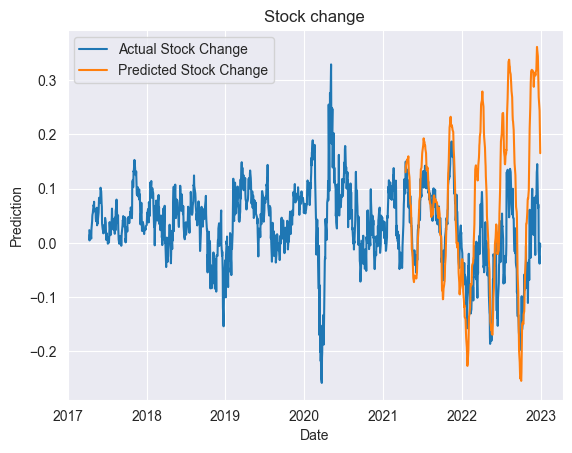

In [27]:
# Creates dataframe with the timeseries index so test targets can be plotted
timeseries_df = pd.DataFrame()
data_df = pd.DataFrame(np.append(y_train, y_test))
timeseries_df = pd.concat([timeseries_df, data_df], axis=1)
timeseries_df.index = msft_df.iloc[window_size:].index
plt.plot(timeseries_df, label="Actual Stock Change")

# Creates dataframe with the timeseries index so test predictions can be plotted
train_set_len = int(len(msft_df) * 0.3)
timeseries_pred_df = pd.DataFrame(y_prediction)
timeseries_pred_df.index = msft_df[len(y_train)+window_size:].index
plt.plot(timeseries_pred_df, label="Predicted Stock Change")
plt.title("Stock change")
plt.xlabel("Date")
plt.ylabel("Prediction")
plt.legend(loc="upper left")